# 1. Estimating PAS using SCAPE

## Data

- We are using single-cell RNA seq data from [Notaras M, Lodhi A, Dündar F, et al. Schizophrenia is defined by cell-specific neuropathology and multiple neurodevelopmental mechanisms in patient-derived cerebral organoids. Mol Psychiatry. 2021;10.1038/s41380-021-01316-6. doi:10.1038/s41380-021-01316-6](https://www.nature.com/articles/s41380-021-01316-6)
- For each sample, add prefix to cell barcode to all BAM files and all barcodes.tsv.gz. Example: C1, C2, KO1, KO2. Processing BAM file can be done using functions `has_tag()` and `set_tag()` in `pysam`.
- For each sample, split BAM file into smaller files by chromosome name. This step can be done by using function `view` by `samtools`.
- For each chromosome, merge BAM files from all samples into one BAM file. This step can be done by using function `merge` by `samtools`.
- For each chromosome, exclude reads whose cell barcodes are not in barcodes.tsv.gz from BAM files. Follow instructions given by Cell Ranger https://kb.10xgenomics.com/hc/en-us/articles/360022448251-How-to-filter-the-BAM-file-produced-by-10x-pipelines-with-a-list-of-barcodes-
- In this example, we extracted data for ELP5 and TGFB1

## Prepare UTR

This step generates coordinate of potential UTRs from given reference annotation file (gff3)

```bash
## This code is run in bash
python -m scape gen_utr_annotation \
--gff_file Homo_sapiens.GRCh38.98.chr.gff3.gz \
--output_dir /your-path/scape/examples/SCZ-nowa-scape \
--res_file_name GRCh38_98 \
--gff_merge_strategy merge
```


## Prepare data per UTR

This step generates reads within potential UTRs derived from the above step. It's done on each BAM file separately.

```bash
## this code is run in bash
input_dir=/your-path/scape/examples/SCZ-nowa-data/merge
output_dir=/your-path/scape/examples/SCZ-nowa-scape
for filename in ${input_dir}/*.bam
do
    python -m scape prepare_input \
    --utr_file /your-path/scape/examples/SCZ-nowa-scape/GRCh38_98.csv \
    --cb_file /your-path/scape/examples/SCZ-nowa-scape/barcodes.tsv.gz \
    --bam_file $filename \
    --output_dir $output_dir \
    --chunksize 100
    
    echo $filename
done
echo "Job is successfully done"
```


## SCAPE inference

This step infers position of PA site from data derived in the above step.

```bash
## This code is run in bash
output_dir=/your-path/scape/examples/SCZ-nowa-scape

for filename in ${output_dir}/pkl_input/*.input.pkl
do
    python -m scape infer_pa \
    --pkl_input_file $filename \
    --output_dir $output_dir
    
    echo "Finish processing ${filename}"
done
```


## Merge PA within junction per gene or utr

Those spurious PA sites within the same junction site are collapsed.

```bash
## This code is run in bash

python -m scape merge_pa \
--output_dir /your-path/scape/examples/SCZ-nowa-scape \
--utr_merge True
```


## Calculate expected length of PA

The expected length of PA per gene is calculated as following:

```bash
## This code is run in bash
python -m scape cal_exp_pa_len \
--output_dir /your-path/scape/examples/SCZ-nowa-scape \
--cell_cluster_file /your-path/scape/examples/SCZ-nowa-scape/author_cell_type_cond.csv \
--res_pkl_file res.gene.pkl
```

## Extract read count matrix

```bash
## This code is run in bash

python -m scape ex_pa_cnt_mat \
--output_dir /your-path/scape/examples/SCZ-nowa-scape \
--res_pkl_file res.gene.pkl
```

The output looks like following:


```python
## This code is run in python
import pandas as pd

df = pd.read_csv("/your-path/scape/examples/SCZ-nowa-scape/res.gene.cnt.tsv.gz", index_col="pa_info")
df.iloc[1:5,1:5]
>>>
                                           C1_AAACCTGAGAGCCTAG-1  C1_AAACCTGAGCCCGAAA-1  C1_AAACCTGAGTACGCGA-1  C1_AAACCTGAGTGGCACA-1
pa_info                                                                                                                              
chr19:41330973:10.0:-:2:ENSG00000105329:1                    0.0                    0.0                    0.0                    0.0
chr17:7254906:10.0:+:1:ENSG00000170291:1                     0.0                    0.0                    0.0                    0.0
chr17:7259921:30.0:+:2:ENSG00000170291:1                     0.0                    0.0                    1.0                    0.0
```

# 2. Differential APA usage using DEXseq

### Visualization cell types

In [6]:
## This code is run in R
library(Seurat)
library(data.table)
library(magrittr)
library(png)
library(grid)
library(gridExtra)
library(ggrepel)
library(tidyr)
library(ggplot2)
source("/your-scape/scape/examples/Rscript-DEXseq/DifferentialTest.R")
source("/your-scape/scape/examples/Rscript-DEXseq/Annotation.R")


Loading required package: SingleCellExperiment



[[1]]


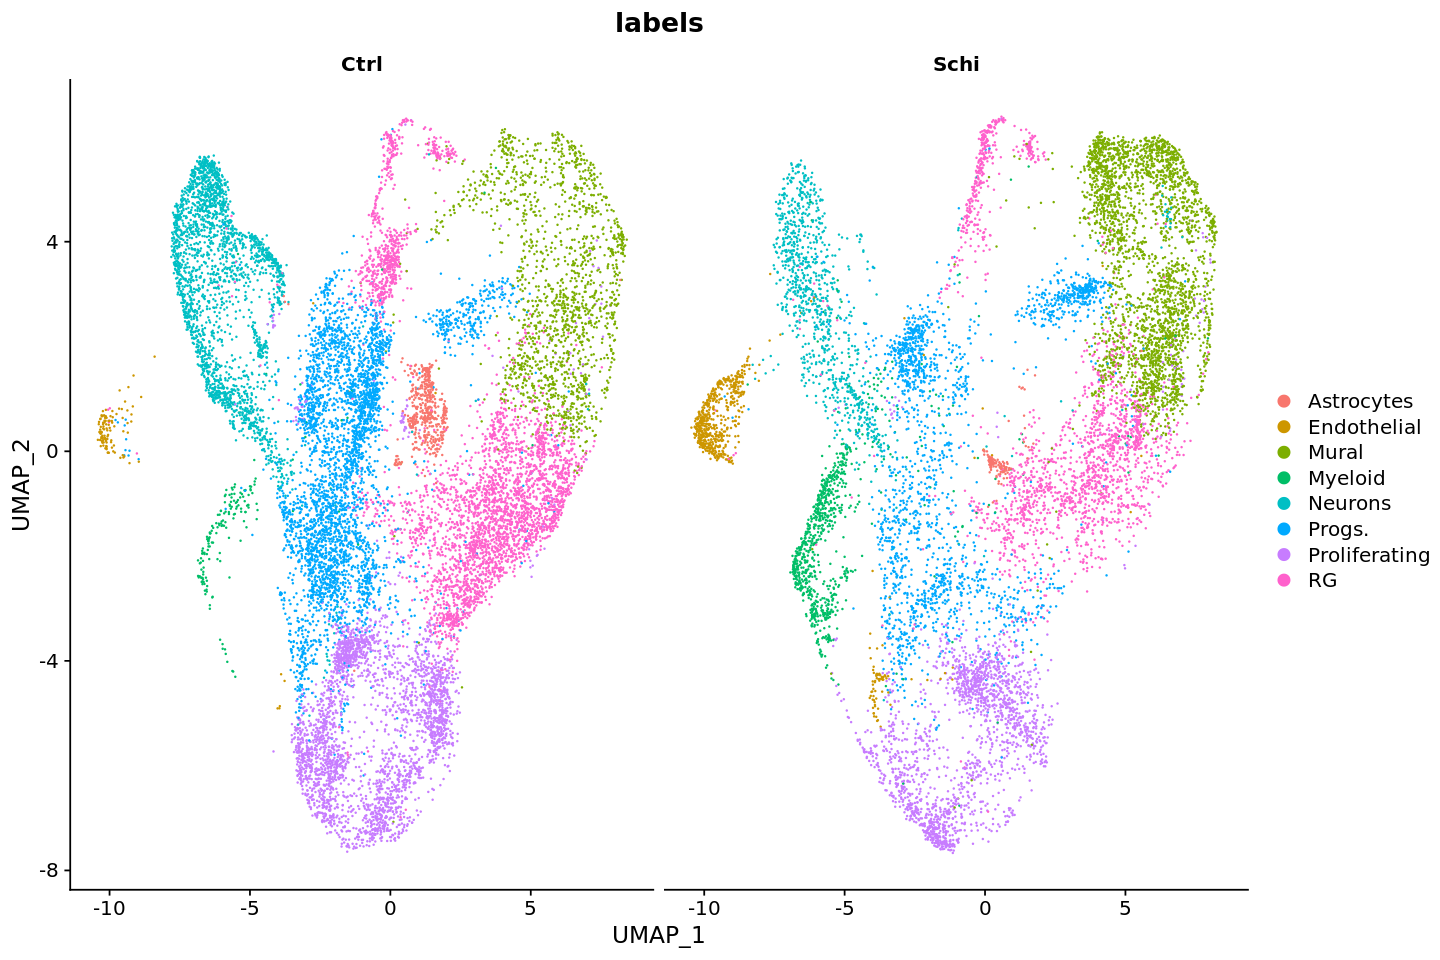

In [3]:
## Convert SingleCellExperiment object to Seurat object
scf <- readRDS("/.../sce_celllabel_new.RDS")
seurat_celllabel <- as.Seurat(scf)

## Plot cell types on reduced dimension 
options(repr.plot.width=12, repr.plot.height=8)
DimPlot(seurat_celllabel, label.size=10, group.by = c("labels"), split.by="control_group" , combine = FALSE)

### Perform differential PA expression analysis

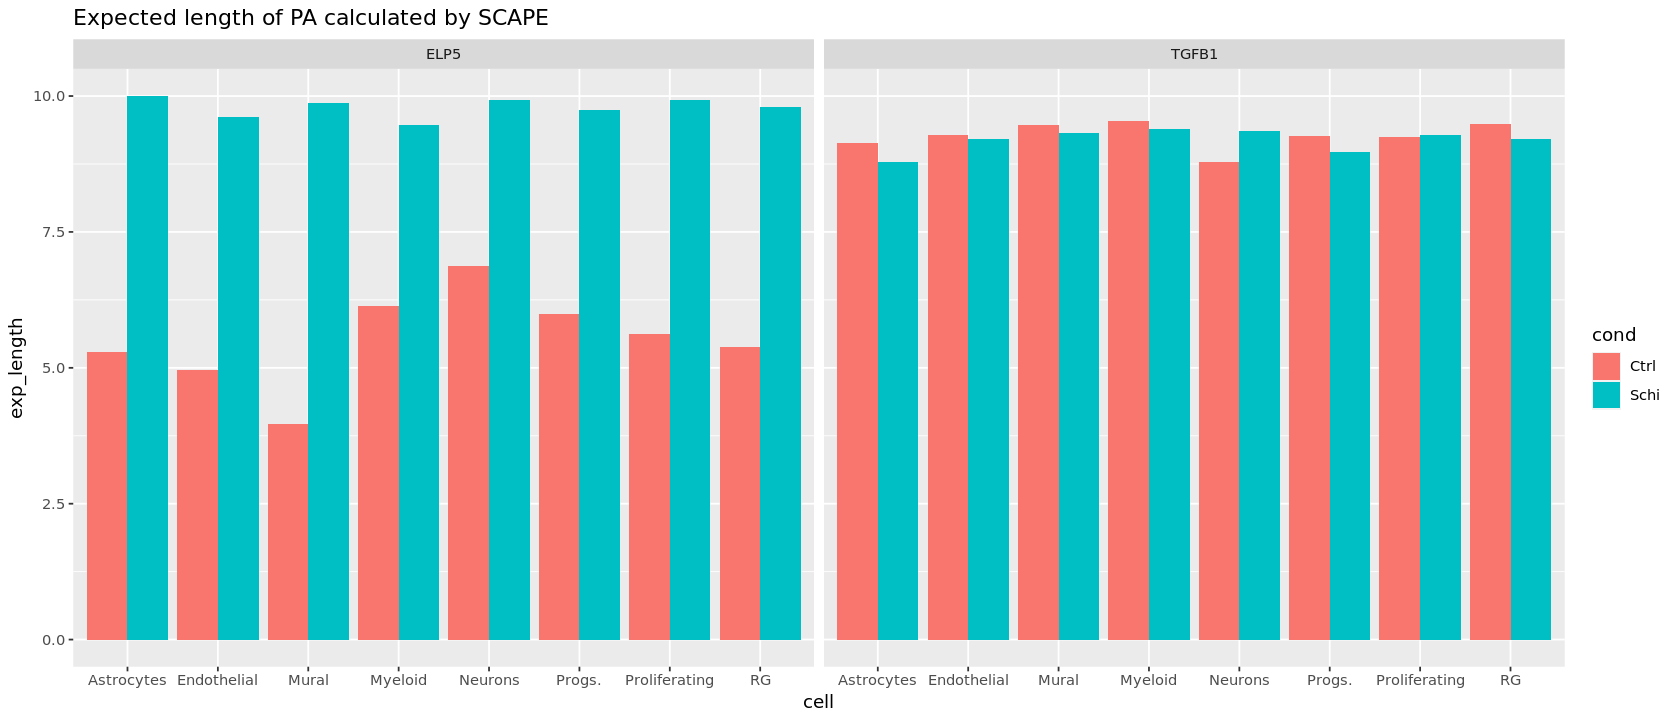

In [4]:
## Expected PA length per gene calculated by SCAPE
## This code is run in R
exp.pa <- fread("/your-scape/scape/examples/SCZ-nowa-scape/author_cell_type_cond.gene.pa.len.csv")
exp.pa <- exp.pa[exp.pa$cell_cluster != 'NA-NA',] %>% separate(col="cell_cluster"
                                                               , sep="-", into=c("cell", "cond"))
exp.pa[exp.pa$gene_id=="ENSG00000170291:1", "gene_name"] <- "ELP5"
exp.pa[exp.pa$gene_id=="ENSG00000105329:1", "gene_name"] <- "TGFB1"
options(repr.plot.width=14, repr.plot.height=6)
ggplot(data=exp.pa, aes(x=cell, y=exp_length, fill=cond)) +
    geom_bar(stat="identity", position=position_dodge())+
    ggtitle("Expected length of PA calculated by SCAPE")+
    facet_wrap(~gene_name)

In [5]:
## Perform DEXseq2
## This code is run in R
cnt.mtx <- as.matrix(fread("/your-scape/scape/examples/SCZ-nowa-scape/res.gene.cnt.tsv.gz"),rownames="pa_info")

cb <- fread("/your-scape/scape/examples/SCZ-nowa-scape/barcode_index.csv") %>% as.data.frame()
rownames(cb) <- cb$index
cell <- fread("/your-scape/scape/examples/SCZ-nowa-scape/author_cell_type_cond.csv") %>% as.data.frame()
rownames(cell) <- cb$index
cb["cell"] <- cell[rownames(cb), "group"]
rownames(cb) <- cb$CB

annot <- AnnotationSite(rownames(cnt.mtx),
                       "/.../cell-ranger-6.0.1/genes_cellranger_GrCh38_2020.gtf",
                       'Hg38',
                       minoverlap=1L,
                       annotLevels = c(
                         "3UTRs",
                         "5UTR", ##tien change order
                         "Exon",
                         "Intron",
                         "CDS",
                         "LastExon1Kb",
                         "3UTRs_1kb",
                         "3UTRs_2kb",
                         "INTERGENIC"
                       ),
                       cores = 1) 

annot <- annot$annot_res_uni_lst
cnt.srt <- CreateSeuratObject(counts=cnt.mtx
                              , meta.data=cb
                             )
Idents(cnt.srt) <- "cell"

dxr.res <- FindDE(cnt.srt,
                   idents.1="Mural-Ctrl",
                   idents.2="Mural-Schi",
                   annot,
                   paLoc = '3UTRs',
                   slot = 'counts',
                   assay = 'RNA',
                   seedUse = 1,
                   cores = 1,
                   num.splits = 6)


```python
>>> dxr.res
                                              gene
ELP5:chr17_7254906_10.0_+_1_ENSG00000170291_1 ELP5
ELP5:chr17_7259921_30.0_+_2_ENSG00000170291_1 ELP5
                                                                               pa_info
ELP5:chr17_7254906_10.0_+_1_ENSG00000170291_1 chr17:7254906:10.0:+:1:ENSG00000170291:1
ELP5:chr17_7259921_30.0_+_2_ENSG00000170291_1 chr17:7259921:30.0:+:2:ENSG00000170291:1
                                                  pct.1       pct.2
ELP5:chr17_7254906_10.0_+_1_ENSG00000170291_1 0.3098592 0.002424242
ELP5:chr17_7259921_30.0_+_2_ENSG00000170291_1 0.1901408 0.161212121
                                                                versus
ELP5:chr17_7254906_10.0_+_1_ENSG00000170291_1 Mural-Ctrl_Vs_Mural-Schi
ELP5:chr17_7259921_30.0_+_2_ENSG00000170291_1 Mural-Ctrl_Vs_Mural-Schi
                                                     p_val    p_val_adj
ELP5:chr17_7254906_10.0_+_1_ENSG00000170291_1 3.619347e-18 3.619347e-18
ELP5:chr17_7259921_30.0_+_2_ENSG00000170291_1 3.619339e-18 3.619347e-18
                                              avg_logFC
ELP5:chr17_7254906_10.0_+_1_ENSG00000170291_1  4.385643
ELP5:chr17_7259921_30.0_+_2_ENSG00000170291_1 -2.623683
```



According to expected length of PA calculated by SCAPE, ELP5 seems to be longer in Schizophrenia compared to Control, while TGFB1 has its PA sites expressed similarly in both conditions.

Since ELP5 is on forward strand, position _7254906_ is the proximal PA site and position _7259921_ is the distal PA site. 
The result by DEXseq2 shows that the proximal PA site is used more in Control ($pct.1: 0.309 > 0.19$), while Schizophrenia mostly uses the distal PA site ($pct.2: $0.161 > 0.002$).

The plot of read coverage below again proves that ELP5 utilises more distal PA in Schizophrenia, while TGFB1 expresses the same proportion of PA sites in both conditions.

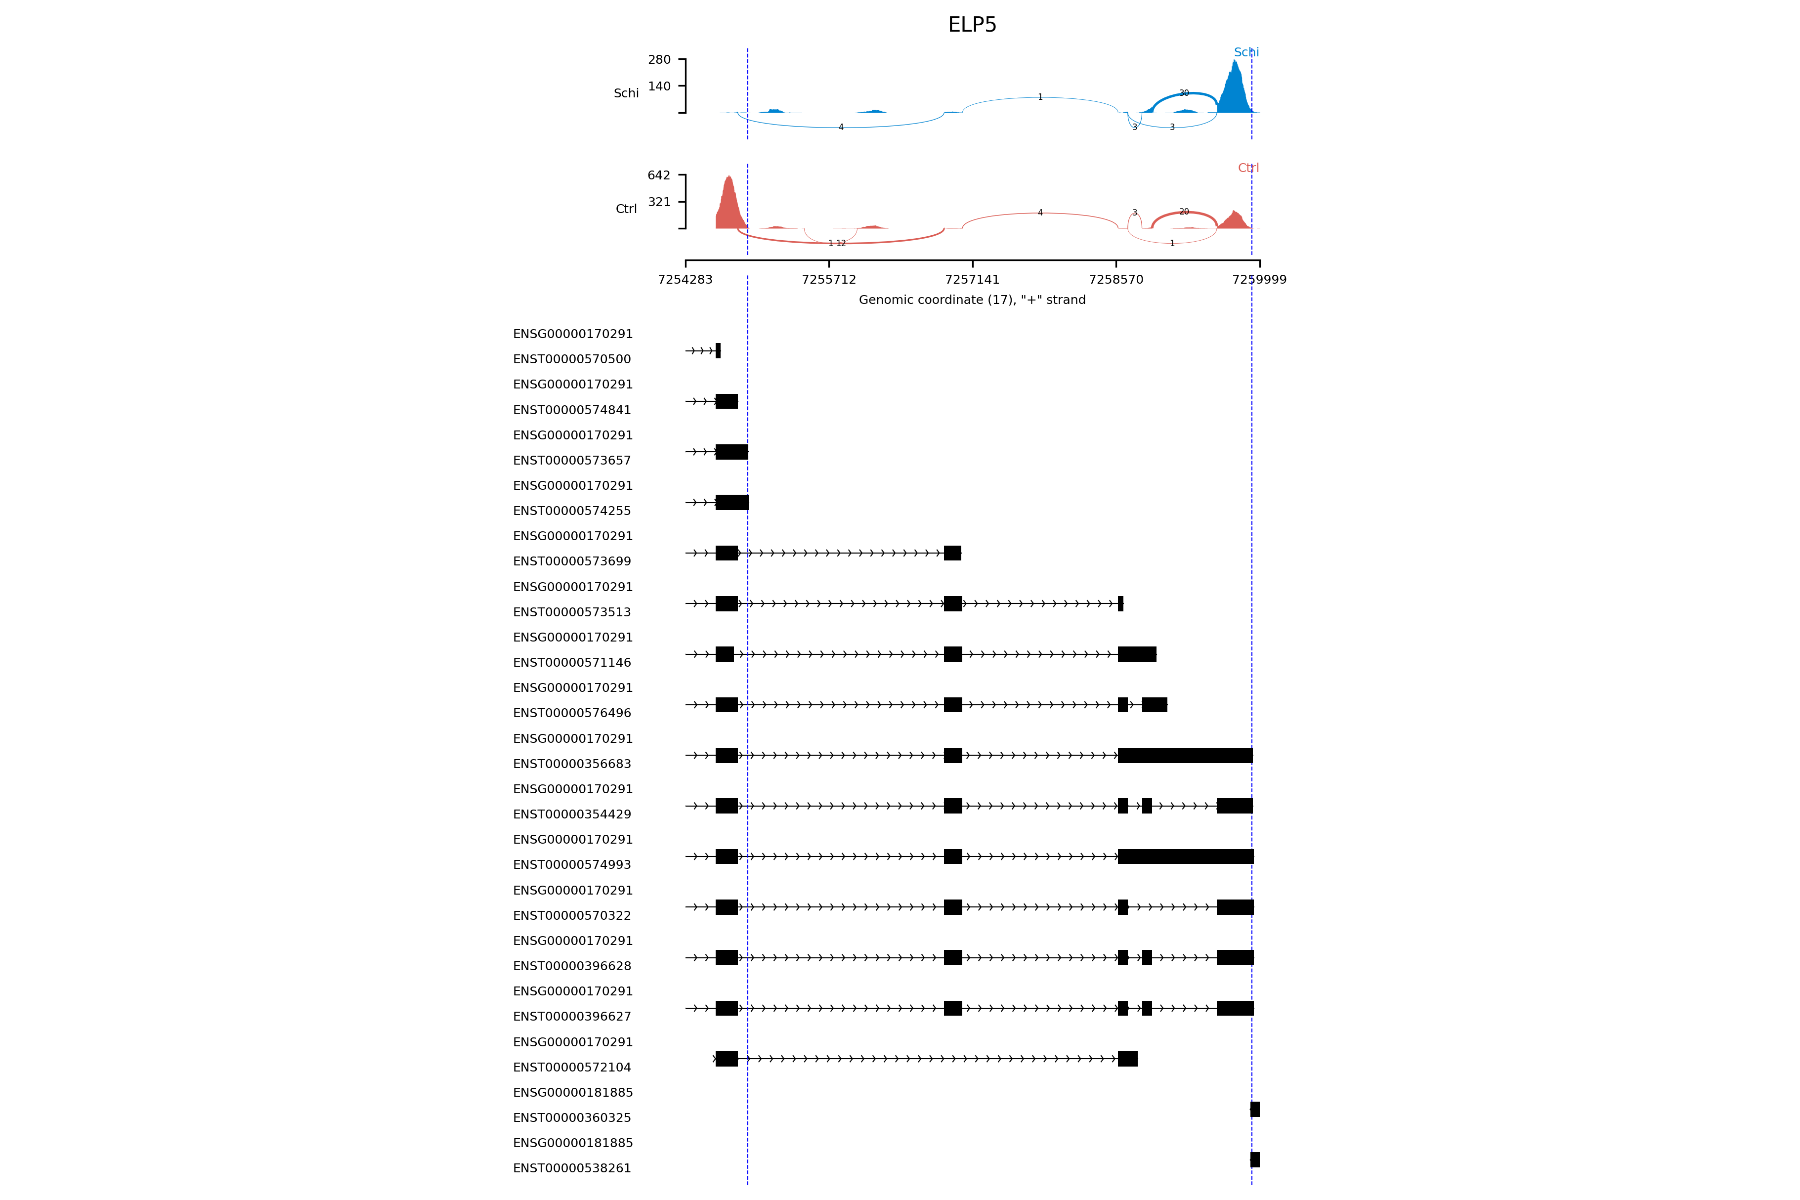

In [7]:
## Read coverage plot of ELP5 in Mural cells

options(repr.plot.width=15, repr.plot.height=10)
img <- png::readPNG("/your-scape/scape/examples/SCZ-nowa-scape/ELP5.png")
grid::grid.raster(img)


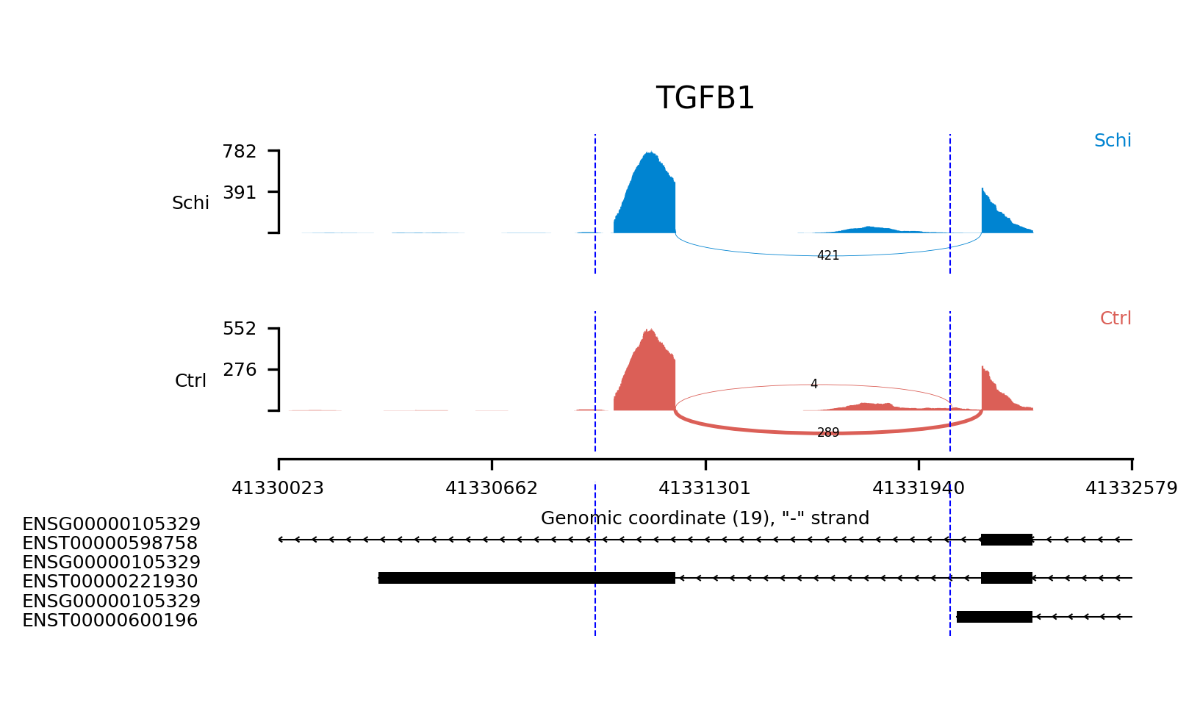

In [8]:
## Read coverage plot of TGFB1 in Mural cells

options(repr.plot.width=10, repr.plot.height=6)
img <- png::readPNG("/your-scape/scape/examples/SCZ-nowa-scape/TGFB1.png")
grid::grid.raster(img)

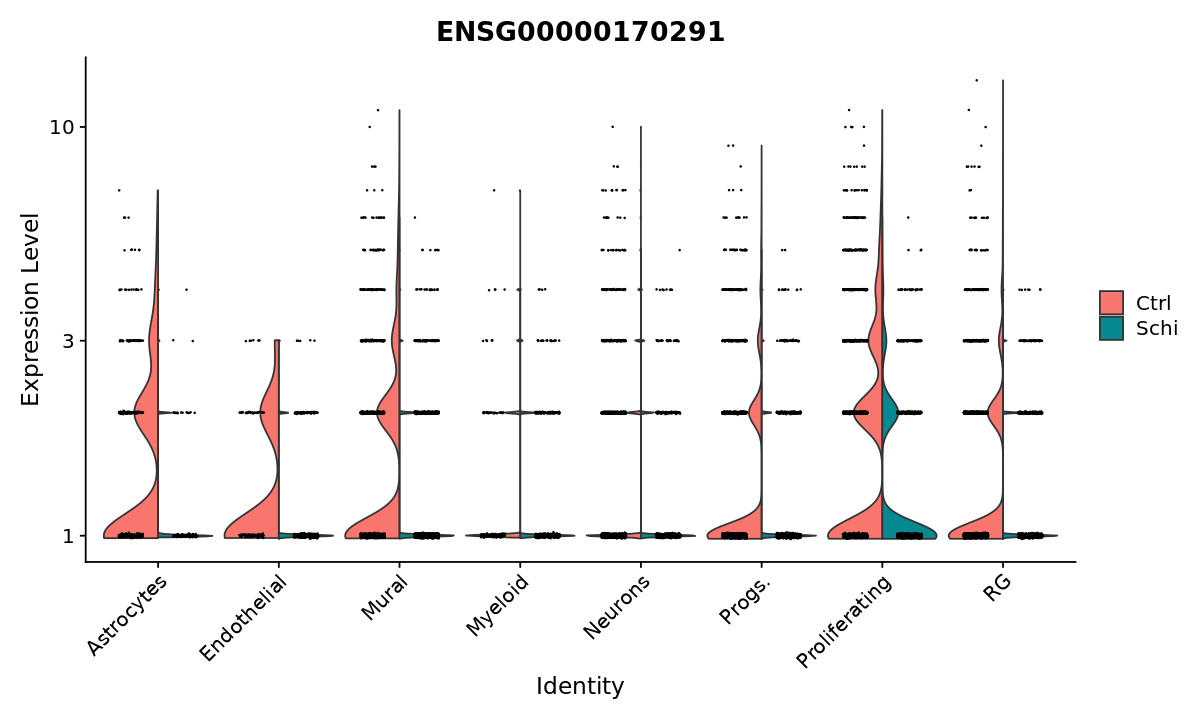

In [10]:
## Compare distribution of expression level of ELP5 between Schizophrenia and Control in each cell type

VlnPlot(seurat_celllabel, features = c("ENSG00000170291"), split.by="control_group"
        , group.by=c("labels"), split.plot=TRUE, log = TRUE)